Previous Models

5 layers with early stopping

100%|██████████| 344862509/344862509 [00:11<00:00, 29929752.77it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 321948.11it/s]


100%|██████████| 14989/14989 [00:00<00:00, 11194519.70it/s]


Epoch [1/20], Train Loss: 11.1368, Test Loss: 5.4219, Test Accuracy: 2.85%
0
Epoch [2/20], Train Loss: 7.0505, Test Loss: 4.7942, Test Accuracy: 6.91%
0
Epoch [3/20], Train Loss: 3.4557, Test Loss: 4.9555, Test Accuracy: 13.09%
1
Epoch [4/20], Train Loss: 2.3601, Test Loss: 5.2322, Test Accuracy: 12.46%
2
Epoch [5/20], Train Loss: 1.8673, Test Loss: 5.1538, Test Accuracy: 14.10%
Adjusting learning rate...
0
Epoch [6/20], Train Loss: 1.2897, Test Loss: 4.3205, Test Accuracy: 19.14%
0
Epoch [7/20], Train Loss: 0.8834, Test Loss: 4.2625, Test Accuracy: 18.85%
0
Epoch [8/20], Train Loss: 0.7971, Test Loss: 4.1018, Test Accuracy: 19.19%
0
Epoch [9/20], Train Loss: 0.6704, Test Loss: 4.1281, Test Accuracy: 19.45%
1
Epoch [10/20], Train Loss: 0.6509, Test Loss: 4.2125, Test Accuracy: 19.21%
2
Epoch [11/20], Train Loss: 0.5943, Test Loss: 4.0638, Test Accuracy: 20.82%
0
Epoch [12/20], Train Loss: 0.5703, Test Loss: 4.0460, Test Accuracy: 20.72%
0
Epoch [13/20], Train Loss: 0.5240, Test Loss: 4

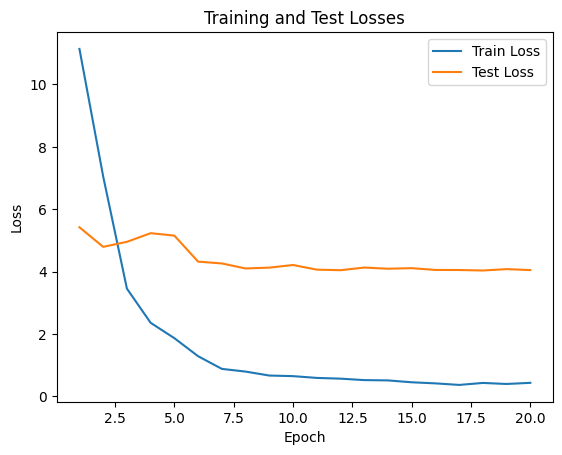

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Preprocess and load the dataset
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Flowers102(root='./data', split='train', transform=data_transform, download=True)
test_dataset = Flowers102(root='./data', split='test', transform=data_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define a convolution neural network
class Network(nn.Module):
    def __init__(self, num_classes):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*106*106, num_classes)

    def forward(self, input): #add dropout between each layer
        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.pool(output)
        output = F.relu(self.bn4(self.conv4(output)))
        output = F.relu(self.bn5(self.conv5(output)))
        output = output.view(-1, 24*106*106)
        output = self.fc1(output)

        return output

# Instantiate a neural network model
num_classes = 102  # Number of classes in Flowers102 dataset
model = Network(num_classes)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # was 0.0001

# Train the model
epochs = 20
train_losses = []
test_losses = []
best_test_loss = float("inf")
patience = 3
bad_counter = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {(100 * correct / total):.2f}%')

    # Early stopping and learning rate adjustment
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        bad_counter = 0
    else:
        bad_counter += 1
        if bad_counter >= patience:
            print("Adjusting learning rate...")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1  # Reduce learning rate by a factor of 10
            bad_counter = 0  # Reset bad_counter
    print(bad_counter)

# Plot the training and test losses
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()


2 layers - OPTIMAL MODEL

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Preprocess and load the dataset
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Flowers102(root='./data', split='train', transform=data_transform, download=True)
val_dataset = Flowers102(root='./data', split='val', transform=data_transform, download=True)
test_dataset = Flowers102(root='./data', split='test', transform=data_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


# Define the neural network architecture
class MyCNN(nn.Module):
    def __init__(self, num_channels=3, num_out_ch=[8, 16], img_w=100, img_h=100, num_classes=102):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0],
                               kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(num_out_ch[0])  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1],
                               kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(num_out_ch[1])  # Batch normalization after conv2
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.fc = nn.Linear(in_features=int(img_w/4)*int(img_h/4)*num_out_ch[1], out_features=num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with p=0.5

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)  # Apply dropout after pooling
        x = self.fc(x.reshape(x.shape[0], -1))
        return x

# Initialize the model
num_classes = len(set(train_dataset._labels))
model = MyCNN(num_channels=3, num_out_ch=[16, 32], img_w=224, img_h=224, num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Train the model
epochs = 100
train_losses = []
test_losses = []
val_losses = []
best_test_loss = float("inf")
patience = 3
bad_counter = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {(100*correct_val / total_val):.2f}%')

    # Early stopping and learning rate adjustment
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        bad_counter = 0
    else:
        bad_counter += 1
        if bad_counter >= patience:
            print("Adjusting learning rate...")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1  # Reduce learning rate by a factor of 10
            bad_counter = 0  # Reset bad_counter
    print(bad_counter)

print(f'Final Test Loss: {test_loss}, Final Test Accuracy: {(100 * correct / total):.2f}%')
# Plot the training and test losses
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()



100%|██████████| 344862509/344862509 [00:12<00:00, 28053594.50it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 398927.74it/s]


100%|██████████| 14989/14989 [00:00<00:00, 2773199.06it/s]


Epoch [1/100], Train Loss: 4.9499, Test Loss: 4.4809, Test Accuracy: 4.72%
0
Epoch [2/100], Train Loss: 4.3212, Test Loss: 4.1950, Test Accuracy: 7.95%
0
Epoch [3/100], Train Loss: 3.9015, Test Loss: 3.9978, Test Accuracy: 10.21%
0
Epoch [4/100], Train Loss: 3.6390, Test Loss: 3.8305, Test Accuracy: 12.75%
0
Epoch [5/100], Train Loss: 3.4061, Test Loss: 3.8206, Test Accuracy: 13.25%
0
Epoch [6/100], Train Loss: 3.2506, Test Loss: 3.6863, Test Accuracy: 15.19%
0
Epoch [7/100], Train Loss: 3.0283, Test Loss: 3.6618, Test Accuracy: 15.38%
0
Epoch [8/100], Train Loss: 2.9116, Test Loss: 3.6009, Test Accuracy: 15.94%
0
Epoch [9/100], Train Loss: 2.7937, Test Loss: 3.5796, Test Accuracy: 17.25%
0
Epoch [10/100], Train Loss: 2.6881, Test Loss: 3.5466, Test Accuracy: 17.30%
0
Epoch [11/100], Train Loss: 2.5247, Test Loss: 3.4818, Test Accuracy: 18.78%
0
Epoch [12/100], Train Loss: 2.4655, Test Loss: 3.4842, Test Accuracy: 18.93%
1
Epoch [13/100], Train Loss: 2.3005, Test Loss: 3.4443, Test Acc

OPTIMAL MODEL with improved graphs and using validation set

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Preprocess and load the dataset
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Flowers102(root='./data', split='train', transform=data_transform, download=True)
val_dataset = Flowers102(root='./data', split='val', transform=data_transform, download=True)
test_dataset = Flowers102(root='./data', split='test', transform=data_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


# Define the neural network architecture
class MyCNN(nn.Module):
    def __init__(self, num_channels=3, num_out_ch=[8, 16], img_w=100, img_h=100, num_classes=102):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0],
                               kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(num_out_ch[0])  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1],
                               kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(num_out_ch[1])  # Batch normalization after conv2
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.fc = nn.Linear(in_features=int(img_w/4)*int(img_h/4)*num_out_ch[1], out_features=num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with p=0.5

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)  # Apply dropout after pooling
        x = self.fc(x.reshape(x.shape[0], -1))
        return x

# Initialize the model
num_classes = len(set(train_dataset._labels))
model = MyCNN(num_channels=3, num_out_ch=[16, 32], img_w=224, img_h=224, num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Train the model
epochs = 100
train_losses = []
val_losses = []
test_losses = []
train_accuracy = []
val_accuracy = []
test_accuracy = []
best_test_loss = float("inf")
patience = 3
bad_counter = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy.append(100 * correct_train / total_train)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy.append(100 * correct_val / total_val)

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(100 * correct_test / total_test)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {(100*correct_val / total_val):.2f}%')

    # Early stopping and learning rate adjustment
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        bad_counter = 0
    else:
        bad_counter += 1
        if bad_counter >= patience:
            print("Adjusting learning rate...")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1  # Reduce learning rate by a factor of 10
            bad_counter = 0  # Reset bad_counter
    print(bad_counter)

print(f'Final Test Loss: {test_loss}, Final Test Accuracy: {(100 * correct_test / total_test):.2f}%')

# Plot the training and test losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')
plt.plot(range(1, epochs+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch [1/100], Train Loss: 4.8394, Validation Loss: 4.4025, Validation Accuracy: 6.18%
0


KeyboardInterrupt: 

Cosine Annealing Test (FAILED)

100%|██████████| 344862509/344862509 [00:12<00:00, 27558139.42it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 166603.94it/s]


100%|██████████| 14989/14989 [00:00<00:00, 13070358.14it/s]


Epoch [1/100], Train Loss: 4.9231, Test Loss: 4.4689, Test Accuracy: 5.12%
Epoch [2/100], Train Loss: 4.3306, Test Loss: 4.2112, Test Accuracy: 7.68%
Epoch [3/100], Train Loss: 3.9282, Test Loss: 4.0318, Test Accuracy: 10.60%
Epoch [4/100], Train Loss: 3.6743, Test Loss: 3.9051, Test Accuracy: 12.38%
Epoch [5/100], Train Loss: 3.4599, Test Loss: 3.7928, Test Accuracy: 13.47%
Epoch [6/100], Train Loss: 3.3014, Test Loss: 3.7248, Test Accuracy: 15.60%
Epoch [7/100], Train Loss: 3.1211, Test Loss: 3.6650, Test Accuracy: 15.06%
Epoch [8/100], Train Loss: 2.9154, Test Loss: 3.6285, Test Accuracy: 16.18%
Epoch [9/100], Train Loss: 2.8354, Test Loss: 3.5706, Test Accuracy: 17.35%
Epoch [10/100], Train Loss: 2.7390, Test Loss: 3.5211, Test Accuracy: 18.33%
Epoch [11/100], Train Loss: 2.5595, Test Loss: 3.4969, Test Accuracy: 18.28%
Epoch [12/100], Train Loss: 2.5265, Test Loss: 3.4781, Test Accuracy: 18.10%
Epoch [13/100], Train Loss: 2.4056, Test Loss: 3.4600, Test Accuracy: 18.95%
Epoch [14/

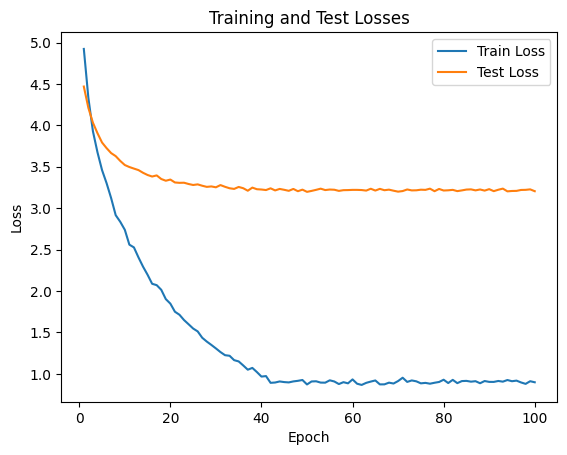

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Preprocess and load the dataset
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Flowers102(root='./data', split='train', transform=data_transform, download=True)
test_dataset = Flowers102(root='./data', split='test', transform=data_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the neural network architecture
class MyCNN(nn.Module):
    def __init__(self, num_channels=3, num_out_ch=[8, 16], img_w=100, img_h=100, num_classes=102):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0],
                               kernel_size=(3,3), stride=(1,1), padding=(1,1))
        #add relu

        self.bn1 = nn.BatchNorm2d(num_out_ch[0])  # Batch normalization after conv1
        #added pooling
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1],
                               kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(num_out_ch[1])  # Batch normalization after conv2
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.fc = nn.Linear(in_features=int(img_w/4)*int(img_h/4)*num_out_ch[1], out_features=num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with p=0.5

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)  # Apply dropout after pooling
        x = self.fc(x.reshape(x.shape[0], -1))
        return x

# Initialize the model
num_classes = len(set(train_dataset._labels))
model = MyCNN(num_channels=3, num_out_ch=[16, 32], img_w=224, img_h=224, num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Train the model
epochs = 100
train_losses = []
test_losses = []
best_test_loss = float("inf")
patience = 3
bad_counter = 0


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {(100 * correct / total):.2f}%')

    # Early stopping and learning rate adjustment
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        bad_counter = 0
    else:
        bad_counter += 1
        if bad_counter >= patience:
            print("Adjusting learning rate...")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1  # Reduce learning rate by a factor of 10
            bad_counter = 0  # Reset bad_counter


# Plot the training and test losses
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

4 layers Adaptive pool with sequential

100%|██████████| 344862509/344862509 [00:11<00:00, 30171027.02it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1229871.85it/s]


100%|██████████| 14989/14989 [00:00<00:00, 22533484.82it/s]


Epoch [1/20], Train Loss: 4.7880, Test Loss: 4.6210, Test Accuracy: 1.11%
Epoch [2/20], Train Loss: 4.7164, Test Loss: 4.5939, Test Accuracy: 1.92%
Epoch [3/20], Train Loss: 4.6418, Test Loss: 4.5629, Test Accuracy: 2.57%
Epoch [4/20], Train Loss: 4.6082, Test Loss: 4.5305, Test Accuracy: 2.75%
Epoch [5/20], Train Loss: 4.5881, Test Loss: 4.5068, Test Accuracy: 2.85%
Epoch [6/20], Train Loss: 4.5456, Test Loss: 4.4775, Test Accuracy: 3.29%
Epoch [7/20], Train Loss: 4.5226, Test Loss: 4.4578, Test Accuracy: 3.37%
Epoch [8/20], Train Loss: 4.4890, Test Loss: 4.4389, Test Accuracy: 3.56%
Epoch [9/20], Train Loss: 4.4735, Test Loss: 4.4258, Test Accuracy: 4.07%
Epoch [10/20], Train Loss: 4.4577, Test Loss: 4.4113, Test Accuracy: 4.10%
Epoch [11/20], Train Loss: 4.4406, Test Loss: 4.4010, Test Accuracy: 4.68%
Epoch [12/20], Train Loss: 4.4021, Test Loss: 4.3862, Test Accuracy: 4.86%
Epoch [13/20], Train Loss: 4.4145, Test Loss: 4.3722, Test Accuracy: 4.96%
Epoch [14/20], Train Loss: 4.3759,

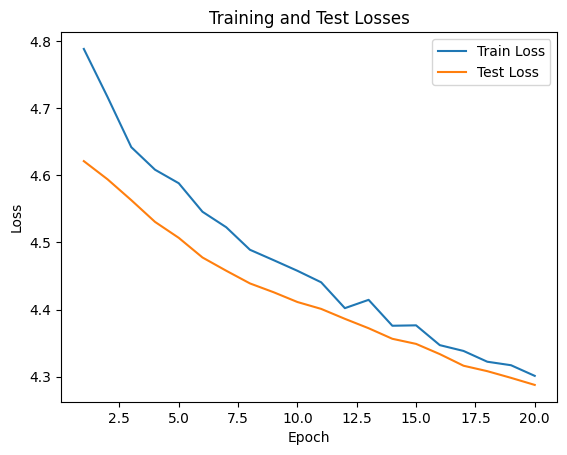

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Preprocess and load the dataset
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Flowers102(root='./data', split='train', transform=data_transform, download=True)
test_dataset = Flowers102(root='./data', split='test', transform=data_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

class MyCNN(nn.Module):
    def __init__(self, num_channels=3, num_out_ch=[8, 16, 32, 64], img_w=100, img_h=100, num_classes=102):
        super(MyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0],
                      kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_out_ch[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

            nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1],
                      kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_out_ch[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

            nn.Conv2d(in_channels=num_out_ch[1], out_channels=num_out_ch[2],
                      kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_out_ch[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

            nn.Conv2d(in_channels=num_out_ch[2], out_channels=num_out_ch[3],
                      kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(num_out_ch[3]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=num_out_ch[3], out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        x = self.classifier(x)
        return x

# Initialize the model
num_classes = len(set(train_dataset._labels))
model = MyCNN(num_channels=3, num_out_ch=[16, 32, 64, 128], img_w=224, img_h=224, num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
epochs = 20
train_losses = []
test_losses = []
best_test_loss = float("inf")
patience = 3
bad_counter = 0

# Cosine Annealing Learning Rate Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {(100 * correct / total):.2f}%')

    # Early stopping and learning rate adjustment
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        bad_counter = 0
    else:
        bad_counter += 1
        if bad_counter >= patience:
            print("Adjusting learning rate...")
            scheduler.step()  # Update learning rate
            bad_counter = 0  # Reset bad_counter

# Plot the training and test losses
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

USING RAY TUNING

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import ray
from ray import train
from ray import tune
from ray.train import Checkpoint
from ray.train.torch import TorchTrainer


# Load the dataset
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the neural network architecture
class MyCNN(nn.Module):
    def __init__(self, num_channels=3, num_out_ch=[8, 16], img_w=128, img_h=128, num_classes=102):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_out_ch[0],
                               kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(num_out_ch[0])
        self.conv2 = nn.Conv2d(in_channels=num_out_ch[0], out_channels=num_out_ch[1],
                               kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(num_out_ch[1])
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.fc = nn.Linear(in_features=int(img_w/4)*int(img_h/4)*num_out_ch[1], out_features=num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.fc(x.reshape(x.shape[0], -1))
        return x

def train(config):
    # Load the dataset with absolute paths
    train_dataset = Flowers102(root='./data', split='train', transform=data_transform, download=True)
    test_dataset = Flowers102(root='./data', split='test', transform=data_transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize the model
    model = MyCNN(num_channels=3, num_out_ch=[config["conv1_out_ch"], config["conv2_out_ch"]],
                  img_w=128, img_h=128, num_classes=102)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])

    # Train the model
    epochs = 5
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    # Use ray.train.report instead of tune.report
    ray.train.report({"accuracy": accuracy})

# Configure Ray Tune
ray.shutdown()
ray.init()
analysis = tune.run(
    train,
    config=config,
    resources_per_trial={"cpu": 2},
    num_samples=10,
)

# Get best hyperparameters
best_config = analysis.get_best_config(metric="accuracy", mode="max")
print("Best hyperparameters:", best_config)




/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-02 09:29:34,153	INFO worker.py:1749 -- Started a local Ray instance.


+--------------------------------------------------------------+
| Configuration for experiment     train_2024-05-02_09-29-36   |
+--------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator       |
| Scheduler                        FIFOScheduler               |
| Number of trials                 10                          |
+--------------------------------------------------------------+

View detailed results here: /root/ray_results/train_2024-05-02_09-29-36
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-05-02_09-29-30_595549_193/artifacts/2024-05-02_09-29-36/train_2024-05-02_09-29-36/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-05-02 09:29:37. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------+
| Trial name          status       conv1_out_ch     conv2_out_ch       

100%|██████████| 344862509/344862509 [00:15<00:00, 22812456.07it/s]


(train pid=41848) Extracting data/flowers-102/102flowers.tgz to data/flowers-102

Trial status: 1 RUNNING | 9 PENDING
Current time: 2024-05-02 09:30:07. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------+
| Trial name          status       conv1_out_ch     conv2_out_ch            lr |
+------------------------------------------------------------------------------+
| train_7e449_00000   RUNNING                32               64   1.20162e-05 |
| train_7e449_00001   PENDING                16               64   0.000133662 |
| train_7e449_00002   PENDING                16               32   0.000913118 |
| train_7e449_00003   PENDING                16               64   2.22106e-05 |
| train_7e449_00004   PENDING                 8               16   1.54268e-05 |
| train_7e449_00005   PENDING                16               16   0.000103507 |
| train_7e449_00006   PENDING                 8  

100%|██████████| 502/502 [00:00<00:00, 1929918.06it/s]


(train pid=41848) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/setid.mat to data/flowers-102/setid.mat


100%|██████████| 14989/14989 [00:00<00:00, 47233976.45it/s]


Trial status: 1 RUNNING | 9 PENDING
Current time: 2024-05-02 09:30:37. Total running time: 1min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+------------------------------------------------------------------------------+
| Trial name          status       conv1_out_ch     conv2_out_ch            lr |
+------------------------------------------------------------------------------+
| train_7e449_00000   RUNNING                32               64   1.20162e-05 |
| train_7e449_00001   PENDING                16               64   0.000133662 |
| train_7e449_00002   PENDING                16               32   0.000913118 |
| train_7e449_00003   PENDING                16               64   2.22106e-05 |
| train_7e449_00004   PENDING                 8               16   1.54268e-05 |
| train_7e449_00005   PENDING                16               16   0.000103507 |
| train_7e449_00006   PENDING                 8               64   0.000142062 |
| train_7e449_00007   PENDING                3

 25%|██▍       | 85819392/344862509 [00:04<00:10, 25473050.90it/s]



Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-05-02 09:38:08. Total running time: 8min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00001   RUNNING                  16               64   0.000133662                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00002   PENDING                  16               32   0.000913118                                          |
| train_7e449_00003   PENDING                  16               64   2.22106e-05               

100%|██████████| 344862509/344862509 [00:14<00:00, 23403531.68it/s]


(train pid=43944) Extracting data/flowers-102/102flowers.tgz to data/flowers-102
(train pid=43944) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat to data/flowers-102/imagelabels.mat


100%|██████████| 502/502 [00:00<00:00, 1716007.02it/s]


(train pid=43944) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/setid.mat to data/flowers-102/setid.mat


100%|██████████| 14989/14989 [00:00<00:00, 49308566.79it/s]


Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-05-02 09:38:38. Total running time: 9min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00001   RUNNING                  16               64   0.000133662                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00002   PENDING                  16               32   0.000913118                                          |
| train_7e449_00003   PENDING                  16               64   2.22106e-05                 

 15%|█▍        | 51445760/344862509 [00:02<00:11, 25724254.51it/s]



Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-05-02 09:44:09. Total running time: 14min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00002   RUNNING                  16               32   0.000913118                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00003   PENDING                  16               64   2.22106e-05              

100%|██████████| 344862509/344862509 [00:14<00:00, 24195686.40it/s]


(train pid=45473) Extracting data/flowers-102/102flowers.tgz to data/flowers-102
(train pid=45473) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat to data/flowers-102/imagelabels.mat


100%|██████████| 502/502 [00:00<00:00, 1855101.86it/s]


(train pid=45473) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/setid.mat to data/flowers-102/setid.mat


100%|██████████| 14989/14989 [00:00<00:00, 46881746.95it/s]


Trial status: 2 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-05-02 09:44:39. Total running time: 15min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00002   RUNNING                  16               32   0.000913118                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00003   PENDING                  16               64   2.22106e-05                

 41%|████▏     | 143065088/344862509 [00:06<00:07, 25468367.83it/s]



Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-05-02 09:49:09. Total running time: 19min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00003   RUNNING                  16               64   2.22106e-05                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1     

100%|██████████| 344862509/344862509 [00:14<00:00, 24095006.48it/s]


(train pid=46749) Extracting data/flowers-102/102flowers.tgz to data/flowers-102
(train pid=46749) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat to data/flowers-102/imagelabels.mat


100%|██████████| 502/502 [00:00<00:00, 1720212.92it/s]


(train pid=46749) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/setid.mat to data/flowers-102/setid.mat


100%|██████████| 14989/14989 [00:00<00:00, 50014656.05it/s]


Trial status: 3 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-05-02 09:49:39. Total running time: 20min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00003   RUNNING                  16               64   2.22106e-05                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1       

 71%|███████▏  | 245989376/344862509 [00:11<00:05, 19097993.74it/s]



Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-05-02 09:55:10. Total running time: 25min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00004   RUNNING                   8               16   1.54268e-05                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1     

100%|██████████| 344862509/344862509 [00:15<00:00, 21631638.27it/s]


(train pid=48262) Extracting data/flowers-102/102flowers.tgz to data/flowers-102
(train pid=48262) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat to data/flowers-102/imagelabels.mat


100%|██████████| 502/502 [00:00<00:00, 1747336.60it/s]


(train pid=48262) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/setid.mat to data/flowers-102/setid.mat


100%|██████████| 14989/14989 [00:00<00:00, 42193572.25it/s]


Trial status: 4 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2024-05-02 09:55:40. Total running time: 26min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00004   RUNNING                   8               16   1.54268e-05                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1       

100%|██████████| 344862509/344862509 [00:14<00:00, 23644396.46it/s]


(train pid=49123) Extracting data/flowers-102/102flowers.tgz to data/flowers-102
(train pid=49123) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat to data/flowers-102/imagelabels.mat


100%|██████████| 502/502 [00:00<00:00, 2152904.51it/s]



Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-05-02 09:58:40. Total running time: 29min 3s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00005   RUNNING                  16               16   0.000103507                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1      

100%|██████████| 14989/14989 [00:00<00:00, 49974898.77it/s]


Trial status: 5 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-05-02 09:59:10. Total running time: 29min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00005   RUNNING                  16               16   0.000103507                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1      

 80%|████████  | 276496384/344862509 [00:11<00:02, 25728704.85it/s]



Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-05-02 10:02:41. Total running time: 33min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00006   RUNNING                   8               64   0.000142062                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1      

100%|██████████| 344862509/344862509 [00:14<00:00, 24038242.68it/s]


(train pid=50218) Extracting data/flowers-102/102flowers.tgz to data/flowers-102
(train pid=50218) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat to data/flowers-102/imagelabels.mat


100%|██████████| 502/502 [00:00<00:00, 2161746.00it/s]


(train pid=50218) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/setid.mat to data/flowers-102/setid.mat


100%|██████████| 14989/14989 [00:00<00:00, 41689935.45it/s]


Trial status: 6 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-05-02 10:03:11. Total running time: 33min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00006   RUNNING                   8               64   0.000142062                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1      

 35%|███▌      | 120815616/344862509 [00:05<00:08, 25053439.21it/s]



Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-05-02 10:07:41. Total running time: 38min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00007   RUNNING                  32               64   0.000170753                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1      

100%|██████████| 344862509/344862509 [00:19<00:00, 18091498.96it/s]


(train pid=51530) Extracting data/flowers-102/102flowers.tgz to data/flowers-102
(train pid=51530) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat to data/flowers-102/imagelabels.mat


100%|██████████| 502/502 [00:00<00:00, 1479649.06it/s]


(train pid=51530) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/setid.mat to data/flowers-102/setid.mat


100%|██████████| 14989/14989 [00:00<00:00, 39465425.40it/s]


Trial status: 7 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-05-02 10:08:11. Total running time: 38min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00007   RUNNING                  32               64   0.000170753                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1      

 42%|████▏     | 146112512/344862509 [00:09<00:09, 20839387.88it/s]



Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-02 10:16:12. Total running time: 46min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00008   RUNNING                  16               32   5.40184e-05                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1     

100%|██████████| 344862509/344862509 [00:17<00:00, 19376873.72it/s]


(train pid=53653) Extracting data/flowers-102/102flowers.tgz to data/flowers-102
(train pid=53653) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/imagelabels.mat to data/flowers-102/imagelabels.mat


100%|██████████| 502/502 [00:00<00:00, 2032375.10it/s]


(train pid=53653) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/setid.mat to data/flowers-102/setid.mat


100%|██████████| 14989/14989 [00:00<00:00, 34038128.13it/s]


Trial status: 8 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-02 10:16:42. Total running time: 47min 5s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00008   RUNNING                  16               32   5.40184e-05                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1       

100%|██████████| 344862509/344862509 [00:15<00:00, 22950770.94it/s]


(train pid=54913) Extracting data/flowers-102/102flowers.tgz to data/flowers-102

Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-05-02 10:21:13. Total running time: 51min 36s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00009   RUNNING                  16               64   1.87446e-05                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TER

100%|██████████| 502/502 [00:00<00:00, 1216372.39it/s]


(train pid=54913) Downloading https://thor.robots.ox.ac.uk/datasets/flowers-102/setid.mat to data/flowers-102/setid.mat


100%|██████████| 14989/14989 [00:00<00:00, 42680531.33it/s]


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-05-02 10:21:43. Total running time: 52min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00009   RUNNING                  16               64   1.87446e-05                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1            288.532

2024-05-02 10:24:24,447	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-05-02 10:24:24,470	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_2024-05-02_09-29-36' in 0.0153s.


Trial status: 9 TERMINATED | 1 RUNNING
Current time: 2024-05-02 10:24:24. Total running time: 54min 47s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------------------------------------------+
| Trial name          status         conv1_out_ch     conv2_out_ch            lr     iter     total time (s)     accuracy |
+-------------------------------------------------------------------------------------------------------------------------+
| train_7e449_00009   RUNNING                  16               64   1.87446e-05                                          |
| train_7e449_00000   TERMINATED               32               64   1.20162e-05        1            489.728    0.0775736 |
| train_7e449_00001   TERMINATED               16               64   0.000133662        1            353.861    0.0962758 |
| train_7e449_00002   TERMINATED               16               32   0.000913118        1            288.53

2024-05-02 10:24:34,499	WARNING tune.py:1054 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)



Best hyperparameters: {'conv1_out_ch': 32, 'conv2_out_ch': 64, 'lr': 0.00017075320416410454}


RESEARCH PAPER WITH OVERFEAT NETWORK ARCHITECTURE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Preprocess and load the dataset with augmented transformations
data_transform = transforms.Compose([
    transforms.Resize((231, 231)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = Flowers102(root='./data', split='train', transform=data_transform, download=True)
test_dataset = Flowers102(root='./data', split='test', transform=data_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the neural network architecture
class MyCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(MyCNN, self).__init__()
        # Initialize the CNN layers with the specified architecture
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Calculate the input size for the fully connected layers dynamically
        self.fc_input_size = self._get_fc_input_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 3072)
        self.fc2 = nn.Linear(3072, 4096)
        self.fc3 = nn.Linear(4096, num_classes)



    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def _get_fc_input_size(self):
        # Forward a dummy input through the convolutional layers to get the output size
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 231, 231)  # Assuming input image size of 231x231
            features_output = self.features(dummy_input)
            return features_output.view(features_output.size(0), -1).shape[1]

# Initialize the model
num_classes = len(set(train_dataset._labels))
model = MyCNN(num_classes=num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Train the model
epochs = 200
train_losses = []
test_losses = []
best_test_loss = float('inf')
patience = 3
counter = 0
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    # Early stopping and learning rate adjustment
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        bad_counter = 0
    else:
        bad_counter += 1
        if bad_counter >= patience:
            print("Adjusting learning rate...")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1  # Reduce learning rate by a factor of 10
            bad_counter = 0  # Reset bad_counter

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {(100 * correct / total):.2f}%')

# Plot the training and test losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()


100%|██████████| 344862509/344862509 [00:05<00:00, 66032297.05it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1194294.16it/s]


100%|██████████| 14989/14989 [00:00<00:00, 31608055.63it/s]


Epoch [1/200], Train Loss: 4.6282, Test Loss: 4.6258, Test Accuracy: 0.33%
Epoch [2/200], Train Loss: 4.6208, Test Loss: 4.5735, Test Accuracy: 4.20%
Epoch [3/200], Train Loss: 4.5234, Test Loss: 4.4350, Test Accuracy: 1.54%
Epoch [4/200], Train Loss: 4.3722, Test Loss: 4.3701, Test Accuracy: 3.24%
Epoch [5/200], Train Loss: 4.3025, Test Loss: 4.3414, Test Accuracy: 2.10%
Epoch [6/200], Train Loss: 4.2352, Test Loss: 4.2759, Test Accuracy: 1.98%
Epoch [7/200], Train Loss: 4.1748, Test Loss: 4.2265, Test Accuracy: 3.27%
Epoch [8/200], Train Loss: 4.1296, Test Loss: 4.2424, Test Accuracy: 2.46%
Epoch [9/200], Train Loss: 4.0644, Test Loss: 4.1952, Test Accuracy: 3.63%
Epoch [10/200], Train Loss: 4.0285, Test Loss: 4.1870, Test Accuracy: 3.27%
Epoch [11/200], Train Loss: 4.0062, Test Loss: 4.2005, Test Accuracy: 4.24%
Epoch [12/200], Train Loss: 3.9978, Test Loss: 4.1653, Test Accuracy: 3.71%
Epoch [13/200], Train Loss: 3.9004, Test Loss: 4.1762, Test Accuracy: 3.85%
Epoch [14/200], Train